In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.metrics as sklm 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.cluster import SpectralClustering

In [7]:
df=pd.read_csv('/content/drive/MyDrive/master dissertation/out2.csv',encoding= 'unicode_escape')

In [5]:
useable_columns = [
'Children_Poverty_Rate',                   
'E1',
'E2',
'E3',
'E4',
'E5',
'E6',
'HD1',
'HD2',
'L1',
'L2',
'O',
'P1',
'P2',
'P3',
'Q']

In [8]:
usable_df = df[useable_columns]

In [9]:
# normalisation
from sklearn import preprocessing
x = usable_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

## optimal kernal PCA

In [15]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# create a new y variable: 1 indicates above median price and 0 indicates otherwise
new_y = usable_df.Children_Poverty_Rate > np.mean(usable_df.Children_Poverty_Rate)

# a pipeline is a way of concatenating many analysis steps. Will introduce the Pipeline in later workshops.
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

# two hyperparamters will be tuned: kernel type, and the gamma of the kernel
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.1, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, new_y)
print(grid_search.best_params_)

{'kpca__gamma': 0.06888888888888889, 'kpca__kernel': 'rbf'}


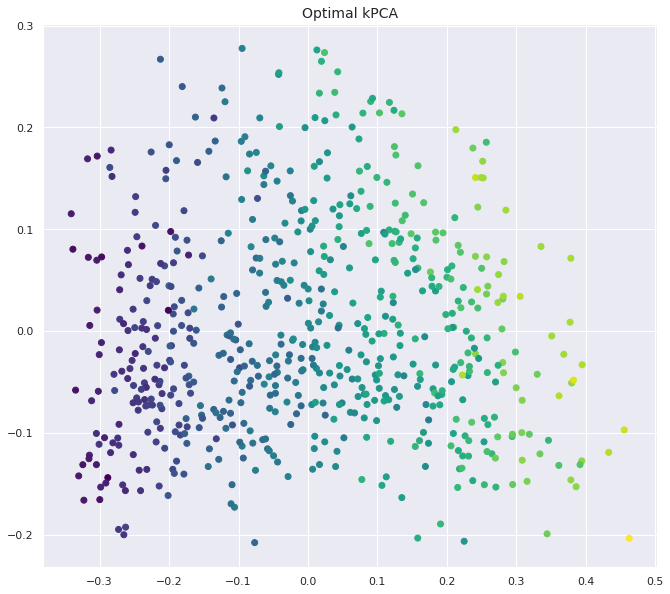

In [17]:
k_pca_opt = KernelPCA(n_components = 2, kernel=grid_search.best_params_['kpca__kernel'], 
                      gamma=grid_search.best_params_['kpca__gamma'], fit_inverse_transform=True)

plt.figure(figsize=(11, 10))
X_reduced = k_pca_opt.fit_transform(X)  
plt.title('Optimal kPCA', fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = usable_df.Children_Poverty_Rate, cmap="viridis")

In [18]:
X_reduced

array([[-0.28529074,  0.16062615],
       [ 0.19858101,  0.01613757],
       [ 0.26496385, -0.12064272],
       ...,
       [ 0.01529698,  0.00899331],
       [-0.06512499, -0.10677269],
       [-0.06103854, -0.10601161]])

k-means

Text(0, 0.5, 'Silhoutte Score')

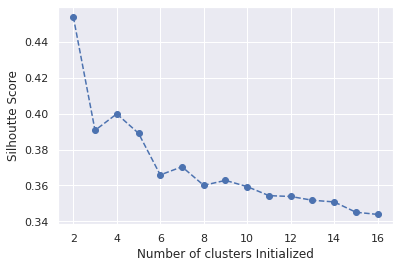

In [19]:
#silhoutte Score and elbow 
silhoutte_scores=[]#silhoutte Score
#intra_sum_of_square_list = [] #elbow

clusters = range(2,17)

for k in clusters:
    km = KMeans(n_clusters=k)
    labels = km.fit(X_reduced).labels_
    score = silhouette_score(X_reduced,labels)
    silhoutte_scores.append(score) #silhoutte Score
    #intra_sum_of_square_list.append(km.inertia_) #elbow
    
plt.plot(clusters, silhoutte_scores, marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters Initialized')
plt.ylabel('Silhoutte Score')

In [21]:
kmeans_pca = KMeans(n_clusters = 2, init = 'k-means++', random_state = 50)
kmeans_pca.fit(X_reduced)
X_reduced.shape

(628, 2)

In [23]:
PAC_Score = pd.DataFrame(X_reduced)
PAC_Score.rename(columns={0:'Component 1',1:'Component 2'})

,Component 1,Component 2
0,-0.285291,0.160626
1,0.198581,0.016138
2,0.264964,-0.120643
3,0.259134,-0.091967
4,0.190932,-0.189562
...,...,...
623,0.382404,-0.048289
624,-0.133551,0.186538
625,0.015297,0.008993
626,-0.065125,-0.106773


In [24]:
df_segm_pca_kmeans = pd.concat([usable_df, PAC_Score], axis=1,ignore_index=True).rename(
    columns={0:"Children_Poverty_Rate",
             1: 'E1',
             2:"E2",
             3: "E3",
             4: "E4",
             5:"E5",
             6:"E6",
             7:'HD1',
             8:"HD2",
             9:'L1',
             10:'L2',
             11:'O',
             12:'P1',
             13:'P2',
             14:'P3',
             15:'Q',
             16:'Component 1',
             17:'Component 2',
             18:'Component 3'
            })
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans

,Children_Poverty_Rate,E1,E2,E3,E4,E5,E6,HD1,HD2,L1,L2,O,P1,P2,P3,Q,Component 1,Component 2,Segment K-means PCA
0,13.9,0.866591,79.632867,78.800000,4.525342,75.265578,24.175824,4.4,3.4,83.704458,82.252816,12.000000,7.500000,77.500000,15.000000,6.200000,-0.285291,0.160626,1
1,34.5,8.748906,60.348077,68.200000,14.488238,58.350165,55.310621,5.1,4.3,82.132476,81.024825,28.472222,25.274725,69.963370,5.128205,14.300000,0.198581,0.016138,0
2,35.7,12.440191,63.107388,67.500000,12.171738,59.268636,60.995185,8.8,6.7,78.301335,75.957605,33.538462,25.961538,63.461538,10.576923,5.800000,0.264964,-0.120643,0
3,34.3,10.731821,61.192441,67.200000,13.811543,57.896693,51.510574,8.8,7.0,78.721642,77.462207,32.571429,24.896266,66.390041,9.128631,7.700000,0.259134,-0.091967,0
4,35.6,10.147133,63.639393,66.800000,12.118492,58.675457,55.239787,9.8,6.8,80.335587,79.273343,30.172414,24.137931,60.591133,15.270936,5.300000,0.190932,-0.189562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,50.2,11.687827,58.998631,64.000000,11.933333,56.404782,60.930233,10.7,8.7,77.968877,74.656310,47.692308,21.235521,69.884170,9.266409,7.400000,0.382404,-0.048289,0
624,17.9,2.016949,71.342032,73.500000,6.018246,69.041185,53.191489,5.3,4.5,84.390921,83.063772,14.000000,8.675799,80.365297,10.958904,10.100000,-0.133551,0.186538,1
625,26.5,5.670490,69.186971,71.700000,8.788799,65.368349,47.823941,6.7,4.9,81.134077,78.892864,22.909762,19.823875,68.815157,11.360375,8.100000,0.015297,0.008993,0
626,20.6,4.200000,71.100000,69.912997,7.300000,64.600000,40.520656,8.3,5.5,80.593332,78.545882,19.278431,18.953092,63.772169,17.274738,5.462242,-0.065125,-0.106773,1


In [25]:
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({
    0:'first',
    1:'second',
})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


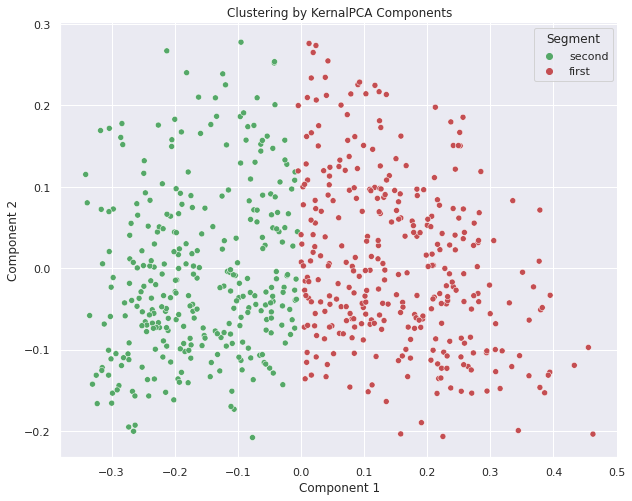

In [27]:
x_axis = df_segm_pca_kmeans['Component 1']
y_axis = df_segm_pca_kmeans['Component 2']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Segment'], palette = ['g','r'])
plt.title('Clustering by KernalPCA Components')
#plt.savefig('image/Clustering_by_PCA_Components_12.png', dpi=300)
plt.show()

In [30]:
spec_cl = SpectralClustering(
    n_clusters=2, 
    random_state=25, 
    n_neighbors=8, 
    affinity='nearest_neighbors'
)

In [32]:
df_segm_kernal_pca_spectral = df_segm_pca_kmeans

In [40]:
df_segm_kernal_pca_spectral['Segment spectral clustering'] = spec_cl.fit_predict(X_reduced)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


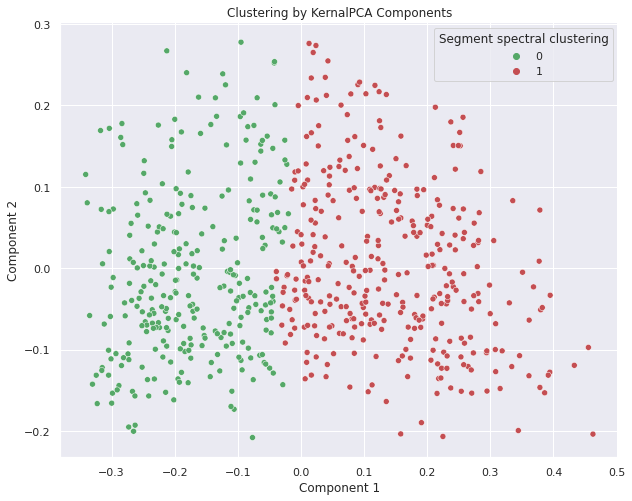

In [41]:
x_axis = df_segm_kernal_pca_spectral['Component 1']
y_axis = df_segm_kernal_pca_spectral['Component 2']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Segment spectral clustering'], palette = ['g','r'])
plt.title('Clustering by KernalPCA Components')
#plt.savefig('image/Clustering_by_PCA_Components_12.png', dpi=300)
plt.show()

In [42]:
ward = gpd.read_file('/content/drive/MyDrive/master dissertation/infuse_ward_lyr_2011/infuse_ward_lyr_2011.shp')

In [43]:
result1 = pd.concat([df_segm_pca_kmeans, df['New Code']], axis=1)

In [44]:
joined1 = ward.merge(result1,left_on = 'geo_code', right_on ='New Code')
joined1.head()

,geo_code,geo_label,geo_labelw,label,name,geometry,Children_Poverty_Rate,E1,E2,E3,...,P1,P2,P3,Q,Component 1,Component 2,Segment K-means PCA,Segment,Segment spectral clustering,New Code
0,E05000251,Askew,None,E92000001E05000251,Askew,"POLYGON ((521826.802 179864.164, 521830.354 17...",31.8,5.742701,71.814926,75.9,...,17.793594,74.021352,8.185053,7.9,0.046038,0.124002,0,first,1,E05000251
1,E05000232,Cazenove,None,E92000001E05000232,Cazenove,"POLYGON ((533654.384 186936.977, 533654.727 18...",25.3,7.160910,64.801444,69.9,...,28.996283,65.055762,5.947955,8.2,0.063760,-0.047187,0,first,1,E05000232
2,E05000605,Leytonstone,None,E92000001E05000605,Leytonstone,"POLYGON ((538967.707 187911.084, 538978.871 18...",22.5,3.809524,70.261171,75.1,...,16.853933,75.280899,7.865169,9.5,-0.025243,0.132965,1,second,0,E05000605
3,E05000063,Woodhouse,None,E92000001E05000063,Woodhouse,"POLYGON ((526331.163 192341.020, 526330.447 19...",19.0,4.865334,72.012103,73.1,...,18.820225,67.134831,13.764045,6.3,-0.080180,-0.029751,1,second,0,E05000063
4,E05000449,New Cross,None,E92000001E05000449,New Cross,"POLYGON ((535270.209 177501.208, 535270.450 17...",35.3,8.013990,64.615913,72.1,...,19.701493,74.626866,5.671642,15.0,0.211528,0.111292,0,first,1,E05000449


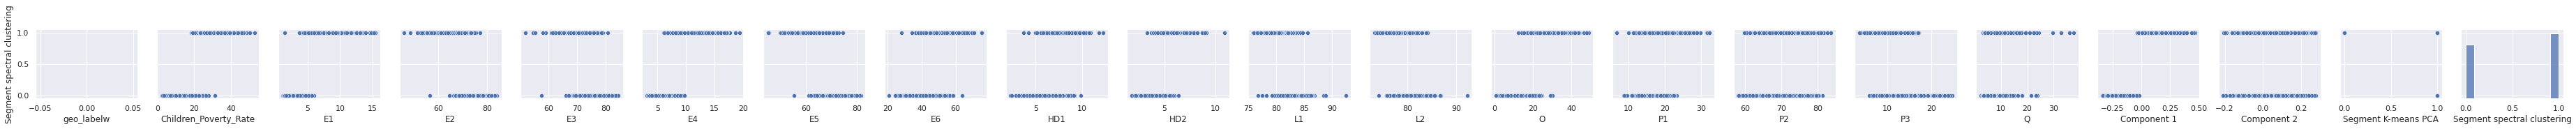

In [55]:
sns.pairplot(joined1, y_vars='Segment spectral clustering')

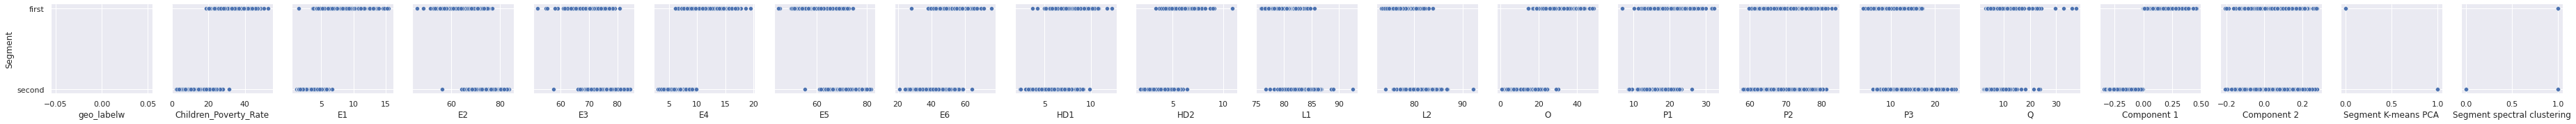

In [56]:
sns.pairplot(joined1, y_vars='Segment')

In [45]:
# find the code for city of london in 2011
c1= ward[ward['geo_code'] =='E36007054']
c2= ward[ward['geo_code'] =='E05000001']
c3= ward[ward['geo_code'] =='E05000015']
c4=ward[ward['geo_code'] =='E36007052']
c5=ward[ward['geo_code'] =='E09000001']
city_of_london = c1.append(c2).append(c3).append(c4).append(c5)

(500648.62694999995, 564876.90205, 153596.64335, 203188.04565000001)

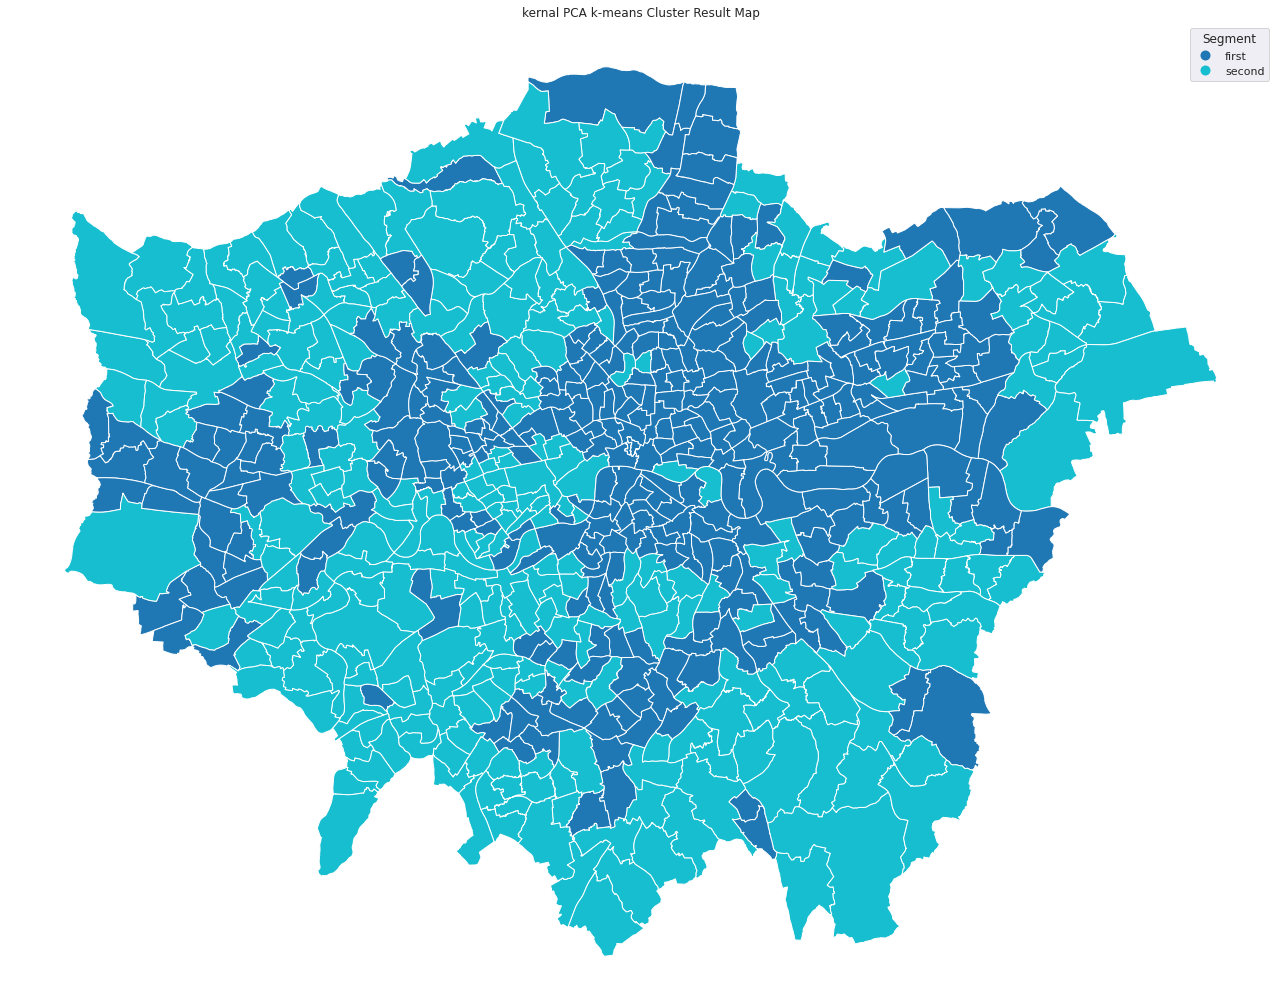

In [47]:
fig, ax = plt.subplots(1,1, figsize=(30,18))
color_sequence = ['#1f77b4', '#aec7e8']
joined1.plot(ax=ax, column='Segment',legend=True)


ax.get_legend().set_title("Segment")  #set the legend title
city_of_london.plot(ax=ax,color='#1f77b4')
plt.title('kernal PCA k-means Cluster Result Map')
ax.axis('off') 

In [48]:
result2 = pd.concat([df_segm_kernal_pca_spectral, df['New Code']], axis=1)

In [49]:
joined2 = ward.merge(result2,left_on = 'geo_code', right_on ='New Code')
joined2.head()

,geo_code,geo_label,geo_labelw,label,name,geometry,Children_Poverty_Rate,E1,E2,E3,...,P1,P2,P3,Q,Component 1,Component 2,Segment K-means PCA,Segment,Segment spectral clustering,New Code
0,E05000251,Askew,None,E92000001E05000251,Askew,"POLYGON ((521826.802 179864.164, 521830.354 17...",31.8,5.742701,71.814926,75.9,...,17.793594,74.021352,8.185053,7.9,0.046038,0.124002,0,first,1,E05000251
1,E05000232,Cazenove,None,E92000001E05000232,Cazenove,"POLYGON ((533654.384 186936.977, 533654.727 18...",25.3,7.160910,64.801444,69.9,...,28.996283,65.055762,5.947955,8.2,0.063760,-0.047187,0,first,1,E05000232
2,E05000605,Leytonstone,None,E92000001E05000605,Leytonstone,"POLYGON ((538967.707 187911.084, 538978.871 18...",22.5,3.809524,70.261171,75.1,...,16.853933,75.280899,7.865169,9.5,-0.025243,0.132965,1,second,0,E05000605
3,E05000063,Woodhouse,None,E92000001E05000063,Woodhouse,"POLYGON ((526331.163 192341.020, 526330.447 19...",19.0,4.865334,72.012103,73.1,...,18.820225,67.134831,13.764045,6.3,-0.080180,-0.029751,1,second,0,E05000063
4,E05000449,New Cross,None,E92000001E05000449,New Cross,"POLYGON ((535270.209 177501.208, 535270.450 17...",35.3,8.013990,64.615913,72.1,...,19.701493,74.626866,5.671642,15.0,0.211528,0.111292,0,first,1,E05000449


In [52]:
joined2['Spectral Segment'] = df_segm_pca_kmeans['Segment spectral clustering'].map({
    0:'first',
    1:'second',
})

(500648.62694999995, 564876.90205, 153596.64335, 203188.04565000001)

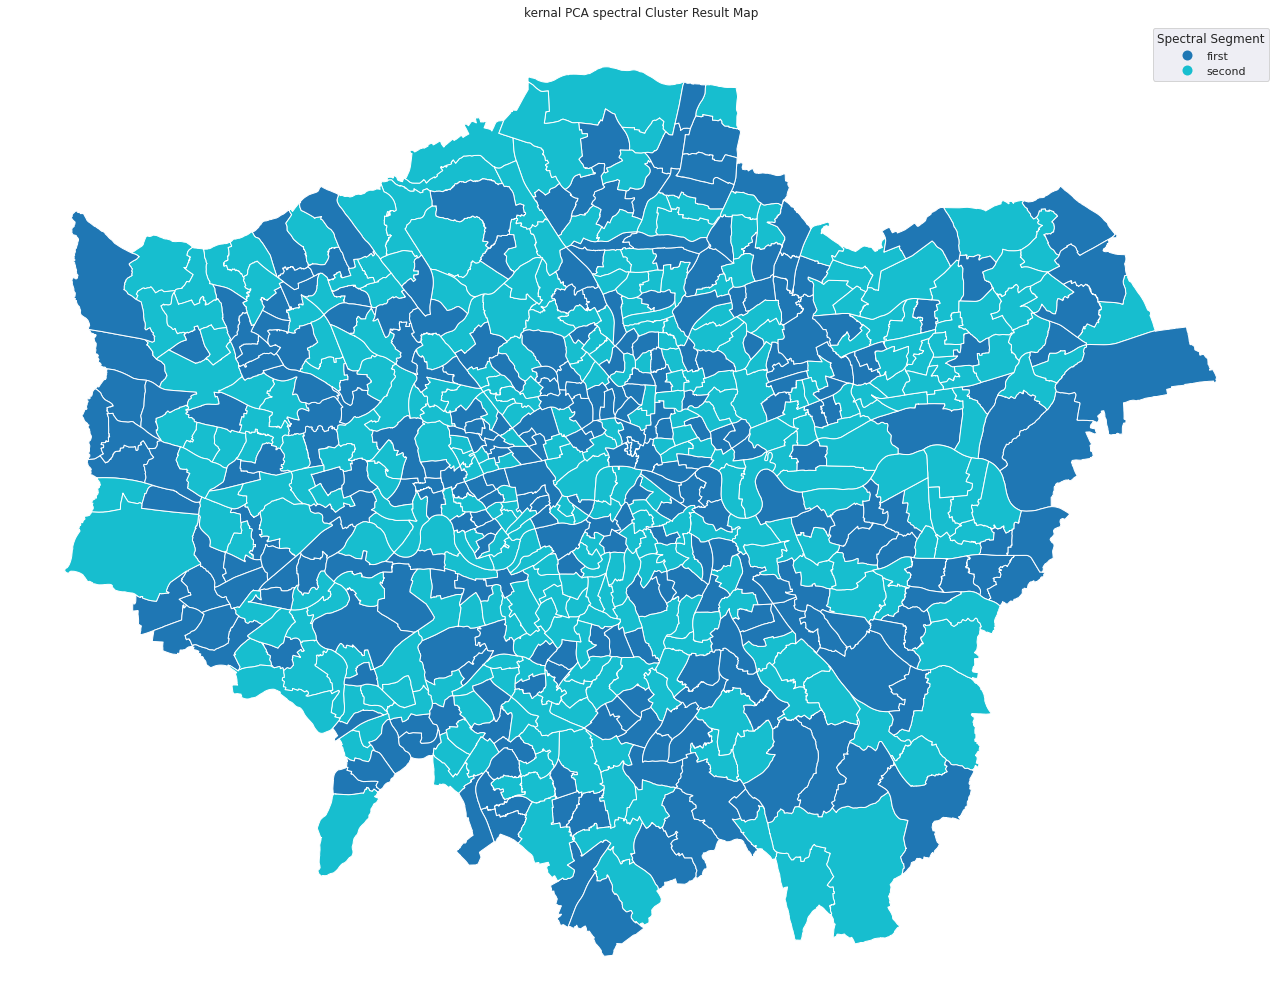

In [53]:
fig, ax = plt.subplots(1,1, figsize=(30,18))
color_sequence = ['#1f77b4', '#aec7e8']
joined2.plot(ax=ax, column='Spectral Segment',legend=True)


ax.get_legend().set_title("Spectral Segment")  #set the legend title
city_of_london.plot(ax=ax,color='#1f77b4')
plt.title('kernal PCA spectral Cluster Result Map')
ax.axis('off') 